# <center><h2>Potato Disease Classification Using Convolution Neural Network</h2></center>
<center>Dataset: https://www.kaggle.com/arjuntejaswi/plant-village</center>

### Importing TensorFlow and Matplotlib

In [2]:
import tensorflow as tf  # Importing TensorFlow for neural network development
from tensorflow.keras import models, layers  # Importing Keras components
import matplotlib.pyplot as plt  # Importing Matplotlib for visualizing model training

### Setting Constants

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 10

<b>Load data into a TensorFlow dataset object.</b>

Utilizing the image_dataset_from_directory API to load all images into a TensorFlow dataset:
 https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
# Creating a TensorFlow dataset using images from the 'PlantVillage' directory with shuffling, specific image size, and batch size
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
# Retrieving the class names from the dataset and storing them in the 'class_names' variable
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
# Extracting and printing the shape of an image batch and corresponding label batch from the dataset (first batch)
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 0 0 2 1 0 1 1 0 0 1 0 0 0 0 1 1 0 2 2 1 1 1 1 0 0 2 0 0 0 0]


As observed in the output above, each element within the dataset consists of a tuple. The first element represents a batch of 32 images, while the second element corresponds to a batch of 32 class labels.

### Visualizing Image Samples from TensorFlow Dataset

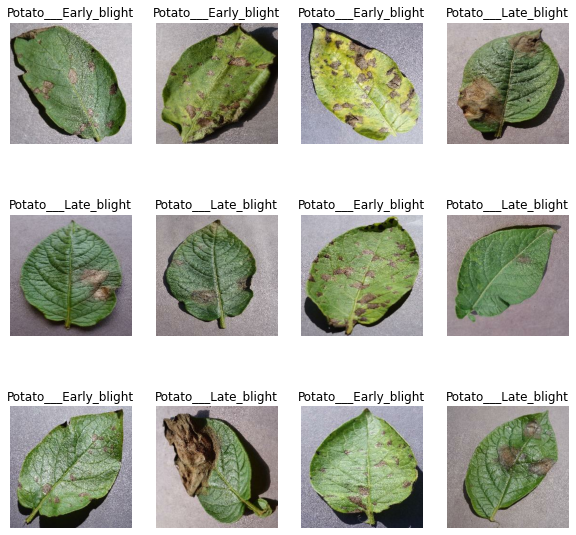

In [7]:
# Setting up a figure for displaying a grid of 12 images with their corresponding class labels
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

<b><h>Splitting the Dataset</h></b>

The dataset is divided into three subsets:

1. Training: This subset is utilized during the model training process.
2. Validation: Used for testing during the training phase.
3. Test: Reserved for evaluating the model after training completion.


### Taining dataset

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

### Validating dataset

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

### Testing data

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

## Dataset Partitioning Function

In [8]:
# Function to split a TensorFlow dataset into training, validation, and test subsets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)
    
  train_ds = ds.take(train_size)    
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
    
  return train_ds, val_ds, test_ds

In [9]:
# Obtaining training, validation, and test subsets using the get_dataset_partitions_tf function
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

### Optimizing TensorFlow Datasets for Training Efficiency

Preparing training, validation, and test datasets with caching, shuffling, and prefetching for enhanced performance

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

## Building the Model

<b>Image Resizing and Rescaling Sequential Model</b>

This sequential model, composed of image resizing and rescaling layers, is designed for preprocessing images, ensuring uniform dimensions (IMAGE_SIZE) and normalizing pixel values to the range [0,1].

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Image Data Augmentation Sequential Model

This sequential model employs data augmentation techniques such as random horizontal and vertical flips, as well as random rotation (with a maximum angle of 0.2 radians), enhancing the diversity of training data for improved model generalization.

In [13]:
# Creating a sequential model for image data augmentation, including random horizontal and vertical flips, and random rotation
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

<b>Applying Data Augmentation to Training Dataset</b>

data augmentation is applied to the training dataset using the map function, introducing randomness through flips and rotations to enhance the model's ability to generalize to different scenarios. The prefetch operation further optimizes the data pipeline for training efficiency.

In [14]:
# Mapping data augmentation to the training dataset: applying random flips and rotations to input images
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Convolutional Neural Network for Image Classification

A Convolutional Neural Network (CNN) is formed using TensorFlow's Keras API for image classification. The architecture includes convolutional and pooling layers, followed by dense layers, designed to classify images into one of three classes. The model is built with the specified input shape.

In [15]:
# Defining a Convolutional Neural Network (CNN) for image classification
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [17]:
# Displaying a summary of the CNN model architecture, including layer types, output shapes, and parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Convolutional Neural Network Model

The CNN model is compiled with the Adam optimizer, Sparse Categorical Crossentropy loss function, and accuracy as the metric for evaluation during training and testing phases.

In [18]:
# Compiling the CNN model with the Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy as the evaluation metric
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

### Training the Convolutional Neural Network

In [20]:
# Training the CNN model using the training dataset, specifying epochs, batch size, and validating on the validation dataset
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 158s 3s/step - loss: 0.8729 - accuracy: 0.5168 - val_loss: 0.7298 - val_accuracy: 0.6667
Epoch 2/10
54/54 [==============================] - 168s 3s/step - loss: 0.5998 - accuracy: 0.7321 - val_loss: 0.4178 - val_accuracy: 0.8490
Epoch 3/10
54/54 [==============================] - 199s 3s/step - loss: 0.4157 - accuracy: 0.8299 - val_loss: 0.5666 - val_accuracy: 0.7917
Epoch 4/10
54/54 [==============================] - 178s 3s/step - loss: 0.3802 - accuracy: 0.8495 - val_loss: 0.3628 - val_accuracy: 0.8542
Epoch 5/10
54/54 [==============================] - 178s 3s/step - loss: 0.3061 - accuracy: 0.8814 - val_loss: 0.2516 - val_accuracy: 0.8802
Epoch 6/10
54/54 [==============================] - 167s 3s/step - loss: 0.1880 - accuracy: 0.9282 - val_loss: 0.1640 - val_accuracy: 0.9271
Epoch 7/10
54/54 [==============================] - 157s 3s/step - loss: 0.2940 - accuracy: 0.8929 - val_loss: 0.6639 - val_accuracy: 0.7604
Epoch 8/10
54

In [21]:
# Evaluating the trained CNN model on the test dataset and obtaining performance scores
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 696ms/step - loss: 0.2239 - accuracy: 0.9102


In [22]:
#Scores is just a list containing loss and accuracy value
scores

[0.22392193973064423, 0.91015625]

In [23]:
# Displaying the parameters used during the training of the CNN model
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [24]:
# Retrieving the keys available in the training history, representing various metrics and losses
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
# Accessing the training loss values from the training history
type(history.history['loss'])

list

In [45]:
# Determining the number of epochs based on the length of the recorded training loss values
len(history.history['loss'])

10

In [26]:
# Displaying the first five training loss values from the training history
history.history['loss'][:5]

[0.8729441165924072,
 0.599789023399353,
 0.41574037075042725,
 0.3802328407764435,
 0.3060663938522339]

### Extracting Training Metrics from History

In [27]:
acc = history.history['accuracy'] # Training accuracy values
val_acc = history.history['val_accuracy'] # Validation accuracy values

loss = history.history['loss'] # Training loss values
val_loss = history.history['val_loss'] # Validation loss values

## Plotting Training and Validation Metrics

Creating a side-by-side visualization of training and validation accuracy in the first subplot and training and validation loss in the second subplot. The plots illustrate the performance of the Convolutional Neural Network (CNN) model over epochs during the training process.

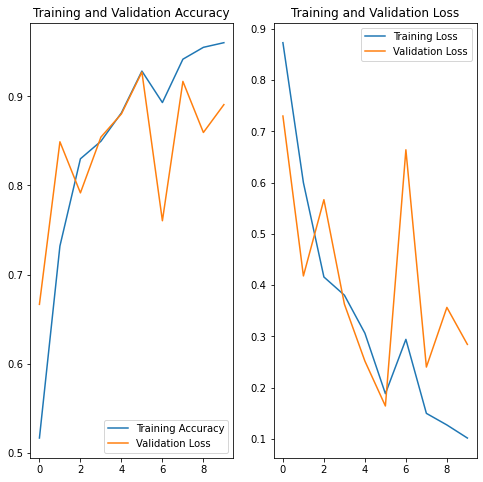

In [28]:
# Visualizing training and validation accuracy, as well as training and validation loss over epochs
plt.figure(figsize=(8, 8))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Prediction on Test Dataset Sample

Making predictions using the trained Convolutional Neural Network (CNN) model on a sample batch from the test dataset. It displays the first image, its actual label, and the predicted label based on the model's predictions.

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


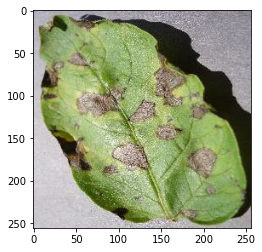

In [29]:
# Evaluating model predictions on a sample batch from the test dataset
import numpy as np

# Extracting the first image and label from the test dataset batch
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  # Performing batch prediction using the trained model
  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

## Image Prediction Function

This function takes a model and an image as input, converts the image to a NumPy array, performs predictions using the model, and returns the predicted class and confidence level. The function assumes the existence of the class_names variable for mapping class indices to labels.

In [30]:
# Function for making predictions using a given model and image
def predict(model, img):
    # Converting the image to a NumPy array and adding a batch dimension
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    # Making predictions using the provided model
    predictions = model.predict(img_array)

    # Extracting the predicted class and confidence level
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

## Model Prediction Visualization

Creating a visualization grid displaying images from a sample batch in the test dataset along with their actual labels, predicted labels, and confidence levels as predicted by the trained Convolutional Neural Network (CNN) model.

1/1 [==============================] - 0s 81ms/step


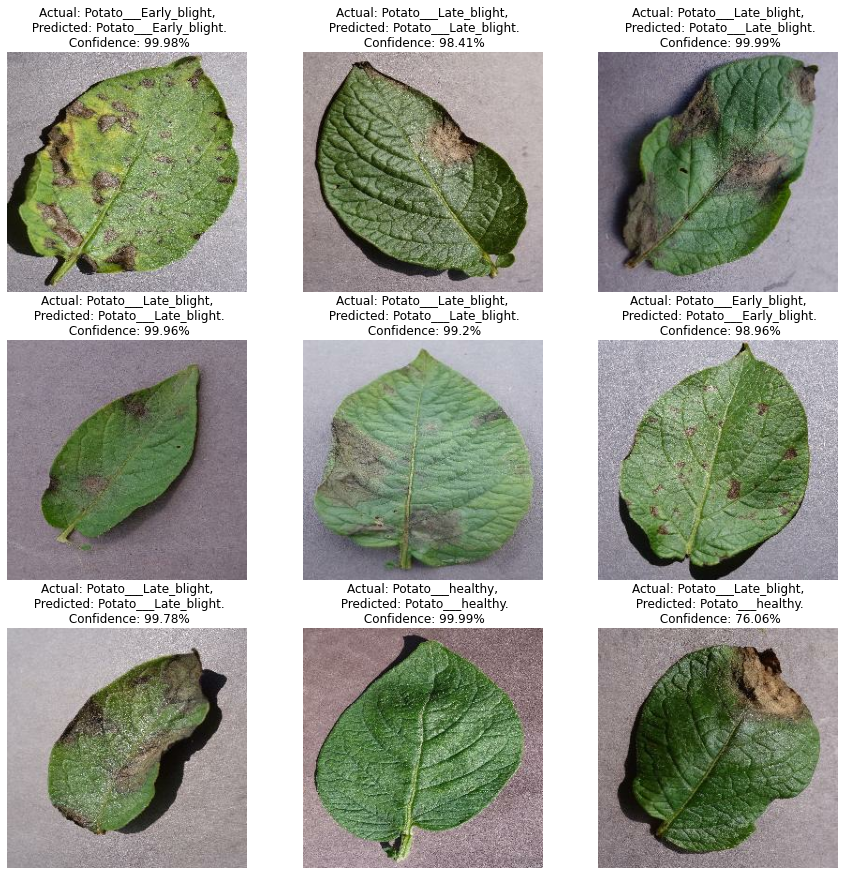

In [31]:
# Visualizing model predictions on a sample batch from the test dataset
plt.figure(figsize=(15, 15))

# Extracting images and labels from the test dataset batch
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Making predictions using the defined function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        # Displaying image titles with actual and predicted labels, along with confidence level
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

<center><h1>Thank You</h1></center>